<a href="https://colab.research.google.com/github/csubhodeep/lyrics_overlay/blob/develop/exp/lyrics_overlay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
img = Image.open('./drive/MyDrive/ColabNotebooks/lyrics_overlay_project/data/test2.png')

In [ ]:
grey_image = img.convert('LA')

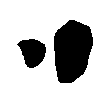

In [ ]:
grey_image

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
grey_image_array = np.array(grey_image)[:,:,0]

In [ ]:
grey_image_array_normalized = MinMaxScaler().fit_transform(grey_image_array)

# Get inferred (segmented) image

Assumptions:
1. The segmentation initially is in the form of rectangular boxes.
2. The input frame is in grey-scale (B&W) and the region inside the bounding box will be filled with black color. (We keep this assumption till we implement the pre-processing function)


In [3]:
!git clone --branch develop https://github.com/csubhodeep/lyrics_overlay.git

Cloning into 'lyrics_overlay'...
fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
import os
os.chdir('./lyrics_overlay')

FileNotFoundError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import differential_evolution

from typing import Tuple, Iterable
from lib.defs import Box, Point, Lyrics, LineSegment
from utils.utils import text_fits_box
from utils.utils import	is_lyrics_box_overlaps_person_box
from utils.utils import get_distance_between_boxes
from utils.utils import get_distance_from_image_edges

In [ ]:
# define loss/cost function
def get_loss(x,  # diagonal coords only,
			 binary_mask: np.ndarray,
			 person_boxes: Iterable[Box],
			 text: Lyrics,
			 font_size: int = 1,  # this should be varied from outside
			 ) -> float:

	try:
		lyrics_box = Box(first_diagonal_coords=Point(coords=(x[0], x[1])),
						 second_diagonal_coords=Point(coords=(x[2], x[3])))
		# TODO: why not exclude certain solutions before triggering the opti algo for faster convergence
		if not text_fits_box(text, font_size=1, box=lyrics_box, form=2):
			loss = 1000
		elif any([is_lyrics_box_overlaps_person_box(lyrics_box, person_box) for person_box in person_boxes]):
			loss = 1000
		else:
			w1 = 0.50
			w2 = 0.50
			# include the following:
			# distance from all person-boxes - w1

			# iterate over all the edges of all person-boxes and find the distances of them from the lyrics-box
			if len(person_boxes):
				distance_persons = tuple([get_distance_between_boxes(person_box, lyrics_box) for person_box in person_boxes])
			else:
				distance_persons = tuple([])

			# balance_1 = np.nan_to_num(np.var(distance_persons))


			# distance from all 4 edges - w2
			distance_edges = get_distance_from_image_edges(binary_mask, lyrics_box)
			# print(distance_persons, distance_edges)

			# balance_2 = np.var(distance_edges)

			# loss = w1*balance_1 + w2*balance_2
			loss = np.var(distance_edges+distance_persons)
	except AssertionError as ex:
		loss = 1000

	return loss

In [ ]:
binary_mask_0 = np.zeros([100, 100])
plt.imshow(binary_mask_0)

In [ ]:
binary_mask_1 = np.zeros([100, 100])
binary_mask_1[40:60, 60:80] = 1
plt.imshow(binary_mask_1)

In [ ]:
binary_mask_2 = np.zeros([100, 100])
binary_mask_2[10:30, 10:30] = 1
binary_mask_2[40:60, 40:60] = 1
binary_mask_2[70:90, 70:90] = 1
plt.imshow(binary_mask_2)

In [ ]:
binary_mask_3 = np.zeros([100, 100])
binary_mask_3[20:60, 10:40] = 1
binary_mask_3[10:30, 65:85] = 1
binary_mask_3[70:90, 50:70] = 1
plt.imshow(binary_mask_3)

In [ ]:
binary_mask_4 = np.zeros([100, 100])
binary_mask_4[20:80, 10:25] = 1
binary_mask_4[20:80, 47:52] = 1
binary_mask_4[20:80, 70:85] = 1
plt.imshow(binary_mask_4)

In [ ]:
# hyper parameters
lyrics = Lyrics("I love you I love you I love you I love you")
limits = (
		(0,100),
		(0,100),
		(0,100),
		(0,100)
	)
# persons_0 = ()
# persons_1 = (
# 		Box(first_diagonal_coords=Point(coords=(60,40)), second_diagonal_coords=Point(coords=(80,60))),
# 	)
persons_2 = (
		Box(first_diagonal_coords=Point(coords=(10,10)), second_diagonal_coords=Point(coords=(30,30))),
		Box(first_diagonal_coords=Point(coords=(40,40)), second_diagonal_coords=Point(coords=(60,60))),
		Box(first_diagonal_coords=Point(coords=(70,70)), second_diagonal_coords=Point(coords=(90,90)))
	)
# persons_3 = (
# 		Box(first_diagonal_coords=Point(coords=(10,20)), second_diagonal_coords=Point(coords=(25,80))),
# 		Box(first_diagonal_coords=Point(coords=(47,20)), second_diagonal_coords=Point(coords=(52,80))),
# 		Box(first_diagonal_coords=Point(coords=(70,20)), second_diagonal_coords=Point(coords=(85,80)))
# 	)
# persons_4 = (
# 		Box(first_diagonal_coords=Point(coords=(10,20)), second_diagonal_coords=Point(coords=(25,80))),
# 		Box(first_diagonal_coords=Point(coords=(47,20)), second_diagonal_coords=Point(coords=(52,80))),
# 		Box(first_diagonal_coords=Point(coords=(70,20)), second_diagonal_coords=Point(coords=(85,80)))
# 	)

In [ ]:
def overlay_box_on_image(box: Box,
                        image: np.ndarray):
    image[box.y1:box.y3, box.x1:box.x3] = -1
    plt.imshow(image)

In [ ]:
res = differential_evolution(get_loss,
								 bounds=limits,
								 args=(binary_mask_2, persons_2, lyrics)
								 )
optimal_box = Box(first_diagonal_coords=Point((res.x[0], res.x[1])),
				  second_diagonal_coords=Point((res.x[2], res.x[3])))

In [ ]:
res

In [ ]:
overlay_box_on_image(optimal_box, binary_mask_2)